# 한국어 Word2Vec 실습

+ 이번 시간에는 Word2Vec에 대해 배워 보겠습니다.
+ 먼저, Word Embedding에 대해 알아보면 Word Embedding은 "단어를 n차원 벡터로 표현하기"입니다.
+ 좀더 상세히 표현하면 토콘(단어)를 의미있는 밀집(dense) Vector 표현하는 겁니다.
+ BOW, TF-IDF 경우 매트릭스 안에 많은 0으로 채워진것을 볼수 있습니다. 희소(sparse) Vector 이며
+ 말뭉치에 단어가 많아질수로 문서의 벡터 길이도 길어지게 됩니다.(차원의 저주)
+ 이런 문제들을 해결하기 위해 Word Embedding을 통해서 단어를 n차원의 밀집벡터로 표현합니다.
+ Word Embedding 방법에는 Word2Vec, FastText, keras 임베딩이 있습니다. 
+ 용어들이 많이 나와 어렵게 느껴지지만, 그냥 Word2Vec, FastText, keras 임베딩은 단순히 단어를 밀집 Vector로 표현하기 라고 생각하시면 됩니다.
+ Word2Vec 된 단어는 단어끼리의 거리 측정이나 단어간 계산이 가능하며 단어가 비슷한지도 유사도 측정할수 있게 됩니다.
+ 여기서는 Word2Vec 이용하여 유사도 측정해 보겠습니다.
+ 참고사이트 : https://wikidocs.net/50739

### 학습목차
1. 필요한 라이브러리 설치 및 임포트
2. 훈련 데이터 불러오기 : A방송사 댓글 데이터
3. 훈련 데이터 전처리 : null, 특수문자 제거 
4. 한글 형태소 분석기 OKT 이용하여 토큰나이즈
5. Word2Vec 훈련시키고 유사도 측정

## 1. 필요한 라이브러리 설치 및 임포트

In [1]:
## 필요한 라이브러리 설치 및 임포트

# openpyxl : 엑셀 파일 읽기 위한 라이브러리
!pip install openpyxl

# gensim : 단어를 의미있는 밀집 vector로 변환하는 Word2Vec 포함하는 라이브러리
# 파이썬(3.10)과 gensim 호환성 및 정상 실행을 위해  gensim버젼 설치 수행
!pip install gensim==4.1.2 

# konlpy : 한글 자연어 처리 패키지 설치
!python3 -m pip install konlpy

import pandas as pd
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from konlpy.tag import Okt

     |████████████████████████████████| 23.6 MB 26.5 MB/s            �█████▋                         | 4.9 MB 26.5 MB/s eta 0:00:01         | 11.8 MB 26.5 MB/s eta 0:00:01█████████████▉       | 18.3 MB 26.5 MB/s eta 0:00:01ta 0:00:01
     |████████████████████████████████| 58 kB 12.6 MB/s             


## 2. 훈련 데이터 불러오기 : A방송사 댓글 데이터

In [2]:
# A_comment_train.xlsx A방송사 댓글 다운로드 및 Pandas read_excel() 함수 활용하여 읽어오기

train_data = pd.read_excel('https://github.com/gzone2000/TEMP_TEST/raw/master/A_comment_train.xlsx', engine='openpyxl')
train_data.tail()

,Unnamed: 0,data,label
246,246,영상F서비스로 간편하게 설치!좋아요\n우리 회사화이팅!,긍정
247,247,모든 업무에서 맡은바 업무에 서 최선을 다하는 모습이 좋습니다! 화이팅 입니다.,긍정
248,248,"사내방송 특성상 최근 이슈화 되거나, 언급이 자주되는 '키워드'를 중심으로 뉴스를 ...",부정
249,249,방송 시간이 너무 길어요.,부정
250,250,"처음 들어보는 말들이 많은데,, 설명이 없어서 힘드네요.",부정


In [3]:
train_data[:5] # 상위 5개 출력

,Unnamed: 0,data,label
0,0,재미는 있는데 시간이 짧은게 아쉽네요~,긍정
1,1,"OO 관련 내용은 우리 직원과는 거리가 멀었음, 특히, 사내에 홍보할 내용은 아니라고 봄",부정
2,2,스토리가 너무 딱딱해서 별로였음,부정
3,3,프로그램A 화이팅하세요!!,긍정
4,4,높은 곳에 올라가는 모습이 너무 위험해 보여요.,부정


In [4]:
print(len(train_data)) # 리뷰 개수 출력

251


## 3. 훈련 데이터 전처리
- null 제거
- 불필요한 특수문자, 숫자등 제거

In [5]:
# NULL 값 존재 유무
print(train_data.isnull().sum())

Unnamed: 0    0
data          0
label         0
dtype: int64


In [6]:
# 'data' 컬럼에 대해 한글 외 문자 제거
train_data['data'] = train_data['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [7]:
train_data[:5] # 상위 5개 출력

,Unnamed: 0,data,label
0,0,재미는 있는데 시간이 짧은게 아쉽네요,긍정
1,1,관련 내용은 우리 직원과는 거리가 멀었음 특히 사내에 홍보할 내용은 아니라고 봄,부정
2,2,스토리가 너무 딱딱해서 별로였음,부정
3,3,프로그램 화이팅하세요,긍정
4,4,높은 곳에 올라가는 모습이 너무 위험해 보여요,부정


## 4. 한글 형태소 분석기 OKT 이용하여 토큰나이즈

In [7]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [8]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 
# 251개 문장 사용하여 금방 수행함

okt = Okt()
tokenized_data = []
for sentence in train_data['data']:
    temp_X = okt.morphs(sentence, stem=True) # 형태소 분류하여 토큰화, stem=True 어간 추출
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

In [9]:
print(tokenized_data[:3])

[['재미', '있다', '시간', '짧다', '아쉽다'], ['관련', '내용', '우리', '직원', '과는', '거리', '멀다', '특히', '사내', '홍보', '내용', '아니다', '봄'], ['스토리', '너무', '딱딱하다', '별로', '이다']]


In [10]:
# 단어 갯수 세기
data_dict = set()
for line in tokenized_data:
    for word in line:
        data_dict.add(word)

len(data_dict)

1039

리뷰의 최대 길이 : 55
리뷰의 평균 길이 : 13.354581673306773


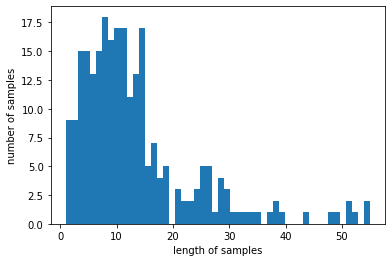

In [11]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 5. Word2Vec 훈련시키고 유사도 측정
- gensim의 word2vec을 이용하여 토큰(단어)을 의미있는 Vector로 만듬
- wv(워드투벡터)의 most_similar 이용하여 유사도 측정

![word2vec](https://user-images.githubusercontent.com/77143767/114329536-8f742100-9b7a-11eb-9d5f-8093393aa6e0.png)

In [12]:
# Word2Vec의 하이퍼파라미터값은 다음과 같습니다.
# vector_size = 워드 벡터의 특징 값. 즉, 위드 임베딩 된 벡터의 차원.
# window = 컨텍스트 윈도우 크기
# min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.). 데이터 적어 0으로 지정
# workers = 학습을 위한 프로세스 수
# sg = 0은 CBOW, 1은 Skip-gram.

# Word2Vec수행하게 되면 A방송사 댓글 데이터의 단어를 50차원의 밀집벡터로 변환하게 된다.

from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, vector_size = 50, window = 5, min_count = 0, workers = 4, sg = 0)

In [13]:
model

In [14]:
# 완성된 임베딩 매트릭스의 크기 확인
# 1039개 단어를 50차원 Vector 표현

model.wv.vectors.shape

(1039, 50)

In [15]:
# 단어 갯수 : 1039
len(model.wv.key_to_index)

1039

In [16]:
# 1039개 단어 나열
model.wv.key_to_index

{'재미': <gensim.models.keyedvectors.Vocab at 0x7faf34e482b0>,
 '있다': <gensim.models.keyedvectors.Vocab at 0x7fafacb994a8>,
 '시간': <gensim.models.keyedvectors.Vocab at 0x7fafacb99518>,
 '짧다': <gensim.models.keyedvectors.Vocab at 0x7faf506fe978>,
 '아쉽다': <gensim.models.keyedvectors.Vocab at 0x7faf506fe7f0>,
 '관련': <gensim.models.keyedvectors.Vocab at 0x7fafa3c84ba8>,
 '내용': <gensim.models.keyedvectors.Vocab at 0x7fafa3c84ac8>,
 '우리': <gensim.models.keyedvectors.Vocab at 0x7fb0b3530898>,
 '직원': <gensim.models.keyedvectors.Vocab at 0x7fb0d9537128>,
 '과는': <gensim.models.keyedvectors.Vocab at 0x7faf349c0160>,
 '거리': <gensim.models.keyedvectors.Vocab at 0x7faf34e50518>,
 '멀다': <gensim.models.keyedvectors.Vocab at 0x7faf34e50828>,
 '특히': <gensim.models.keyedvectors.Vocab at 0x7faf34e503c8>,
 '사내': <gensim.models.keyedvectors.Vocab at 0x7faf34e505c0>,
 '홍보': <gensim.models.keyedvectors.Vocab at 0x7faf34e50550>,
 '아니다': <gensim.models.keyedvectors.Vocab at 0x7faf34e50630>,
 '봄': <gensim.models.k

In [17]:
# 응원 단어에 대한 Word2Vec 변환된 Vector 출력 : 1개 단어를 50차원 표현

print(model.wv.get_vector('응원').shape)
model.wv.get_vector('응원')

(50,)


array([-3.7758637e-03,  4.8720292e-03,  1.2784039e-03,  7.1002706e-03,
       -5.3930082e-03, -4.5674872e-03, -3.8046991e-03, -9.5814383e-03,
        6.2148599e-03, -8.0088153e-03, -8.2606319e-03, -4.7589988e-03,
        5.7572190e-04, -6.6016982e-03, -2.5639667e-03, -5.3087538e-03,
       -1.0365383e-03,  5.9344280e-03,  3.8396413e-03, -1.9217605e-03,
       -1.5206929e-04, -6.8604723e-03, -7.4235415e-03, -1.2511533e-03,
       -6.1341156e-03,  5.7349843e-03,  2.6425549e-03,  7.4315136e-03,
        1.5488573e-04,  5.9423675e-03, -8.1587005e-03,  3.0558436e-05,
       -3.4626951e-03, -5.0817365e-03, -7.0249718e-03,  7.5144707e-03,
       -6.3639078e-03,  3.5880785e-03, -8.9554824e-03,  2.0072411e-03,
       -4.9442458e-03, -9.2201261e-03,  6.2486163e-04, -7.0231264e-03,
       -9.6162397e-04,  4.5720735e-03, -1.9686837e-03,  9.1611994e-03,
       -5.4486771e-03, -4.2048460e-03], dtype=float32)

In [18]:
# 응원 키워드 유사도 조회
print(model.wv.most_similar("노력"))

[('방법', 0.5028175711631775), ('취지', 0.440878689289093), ('환경', 0.39780452847480774), ('또다시', 0.3912457525730133), ('두근두근', 0.38996320962905884), ('처리', 0.375481516122818), ('고', 0.3655272126197815), ('정보', 0.35371559858322144), ('그로', 0.3518138527870178), ('양가', 0.34500551223754883)]


In [19]:
# 코로나 키워드 유사도 조회
print(model.wv.most_similar("코로나"))

[('을', 0.4151023328304291), ('리액션', 0.4021333158016205), ('시청', 0.3945949971675873), ('티핑', 0.3816837966442108), ('부정', 0.3757290840148926), ('줄', 0.3753538429737091), ('셀프', 0.37398213148117065), ('로밍', 0.370808869600296), ('이태원', 0.3661848306655884), ('반영', 0.3596492409706116)]


In [20]:
# 회사 키워드 유사도 조회
print(model.wv.most_similar("회사"))

[('있다', 0.4627591371536255), ('에게', 0.4478223919868469), ('같다', 0.3860618472099304), ('프로', 0.3847924768924713), ('의견', 0.38449323177337646), ('화략', 0.3676826059818268), ('주', 0.3601008355617523), ('모두', 0.35969120264053345), ('원하다', 0.3582097887992859), ('소개', 0.3562643527984619)]


# 배운 내용 정리
1. Word Embedding : 단어를 의미있는 밀집 벡터로 표현하기
2. Word Embedding 방법에는 Word2Vec, FastText 등 있습니다.
3. Word2Vec도 단어를 밀집 벡터로 표현하는 방법이며 
4. Word2Vec 사용하여 단어를 밀집 벡터로 만들면, Cosine유사도 처럼 벡터간의 유사성을 측정할수 있어, 다른 단어와의 유사성을 측정할수 있습니다.
5. 우리는 Word Embedding, Word2Vec 용어의 의미를 잘 기억하면 되겠습니다.